# Data Preparation


In [1]:
# --------------------------------------------------------------------------------------------------------
# emigration.ipynb -- data preparation, inspection, and visualization 
# --------------------------------------------------------------------------------------------------------
# 0.01|02.01.22|AB|creation
# 0.02|03.01.22|AB|save result with pickle
# 0.03|16.01.22|AB|save as csv, name diagram
# 0.04|16.01.22|AB|corrected imputation; minor adaptations
# --------------------------------------------------------------------------------------------------------

# initialize

import numpy as np
import pandas as pd
#import glob
import os
import matplotlib.pyplot as plt

#from datetime import datetime, date 
import re # regular expression
import seaborn as sns

# %matplotlib inline
# %matplotlib notebook

PATH_DATA = r'../../data/'
INTERACTIVE = False
VALUE_COLNAME = 'nEmigrants'  # name for new column containing value of timeseries

if INTERACTIVE:
    %matplotlib notebook
else:
    %matplotlib inline
    

## Emigration

_Total number of long-term emigrants leaving from the reporting country during the reference year._

- information about data availabilty
https://ec.europa.eu/eurostat/web/main/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ&p_p_lifecycle=0&p_p_state=pop_up&p_p_mode=view&_NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ_nodeInfoService=true&nodeId=-9012

- meta data: N/A
Last data update: 	13/03/2021 23:00     
Overall data coverage: 	2008 — 2019
Source data set: https://ec.europa.eu/eurostat/databrowser/product/view/MIGR_IMM1CTZ

for each EU country (35), #immigrants for 2008-2019
special cases: ":" missing;
two sets: agedef = COMPLET (age in completed years) and REACH (age reached during the year), resp.

Missing values are indicated by a colon. 
Numbers may be accompanied by a 1- or 2-letter code with the following meaning:

- b: break in time series
- bp: break in time series, provisional
- p: provisional
- e: estimated
- ep: estimated, provisional

For the purpose of this study, this information is ignored and hence the characters removed, facilitating conversion of the data to numeric.
- NO languages, no source country

In [2]:
fileName = PATH_DATA + 'tps00177.tsv'
# header = 1st line; missing value indicated by colon (followed by a space)
data = pd.read_csv(fileName, sep='\t', na_values=[': '], header=0) 

In [3]:
data

,"citizen,agedef,age,unit,sex,geo\time",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"TOTAL,COMPLET,TOTAL,NR,T,AT",51563,53244,51651,51197,51812,54071,53491,56689,64428,66144,67212,68280
1,"TOTAL,COMPLET,TOTAL,NR,T,BE",NaN,NaN,66013 b,84148 b,93600,102657,94573,89794,92471,89690,88935,102936
2,"TOTAL,COMPLET,TOTAL,NR,T,BG",NaN,NaN,NaN,NaN,16615 bp,19678 p,28727 p,29470 p,30570,31586 p,33225 p,39941 p
3,"TOTAL,COMPLET,TOTAL,NR,T,CH",86130,86036,96839,96494 b,103881,106196,111103,116631,120653,124997,130225,126221
4,"TOTAL,COMPLET,TOTAL,NR,T,CY",4474,4797 b,4293,4895,18105,25227,24038,17183,14892,15105,15340,17373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,"TOTAL,REACH,TOTAL,NR,T,RO",302796 b,246626,197985,195551,170186,161755,172871,194718,207578,242193 e,231661 e,233736 e
62,"TOTAL,REACH,TOTAL,NR,T,SE",45294,39240,48853,51179,51747,50715,51237,55830,45878,45620,46981,47718
63,"TOTAL,REACH,TOTAL,NR,T,SI",12109 b,18788,15937,12024,14378,13384,14336,14913,15572,17555,13527,15106
64,"TOTAL,REACH,TOTAL,NR,T,SK",1705,1979,1889,1863,2003,2770,3644,3870,3801,3466,3298,3384


First column defines content of time series. 
There are two sets: agedef = COMPLET (age in completed years) and REACH (age reached during the year), resp. 
In each group, there is a row for each country of the European Union (last two letters of 1st column).
Since age is no criterion, the two sets are equal and only the first half of the dat is considered.

In [4]:
# remove duplicates and transform first column (keep only country code)

keepNRows = data.shape[0] // 2 # keep first half of table (68 -> 34)
data = data.iloc[0:keepNRows, ]

# keep last two characters (country code) -> new first column 'country'
data.insert(0, 'country', data.iloc[ : , 0].apply(lambda s: s[-2: ])) 
data

,country,"citizen,agedef,age,unit,sex,geo\time",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AT,"TOTAL,COMPLET,TOTAL,NR,T,AT",51563,53244,51651,51197,51812,54071,53491,56689,64428,66144,67212,68280
1,BE,"TOTAL,COMPLET,TOTAL,NR,T,BE",NaN,NaN,66013 b,84148 b,93600,102657,94573,89794,92471,89690,88935,102936
2,BG,"TOTAL,COMPLET,TOTAL,NR,T,BG",NaN,NaN,NaN,NaN,16615 bp,19678 p,28727 p,29470 p,30570,31586 p,33225 p,39941 p
3,CH,"TOTAL,COMPLET,TOTAL,NR,T,CH",86130,86036,96839,96494 b,103881,106196,111103,116631,120653,124997,130225,126221
4,CY,"TOTAL,COMPLET,TOTAL,NR,T,CY",4474,4797 b,4293,4895,18105,25227,24038,17183,14892,15105,15340,17373
5,CZ,"TOTAL,COMPLET,TOTAL,NR,T,CZ",51478 b,61782,61069,55910 b,46106,25894 b,28468,25684,38864,27316,26742,77798
6,DE,"TOTAL,COMPLET,TOTAL,NR,T,DE",737889,286582 b,252456,249045,240001,259328,324221 e,338403 e,533762 be,560700 be,540415 e,576319 be
7,DK,"TOTAL,COMPLET,TOTAL,NR,T,DK",38356 b,39899,41456,41593,43663,43310,44426,44625,52654,56403,60381,66520
8,EE,"TOTAL,COMPLET,TOTAL,NR,T,EE",4406,4658,5294,6214,6321,6740,4637,13003 b,13792,12358,10476,12801
9,EL,"TOTAL,COMPLET,TOTAL,NR,T,EL",43044 b,43686,62041 b,92404,124694,117094,106804 b,109351,106535,103327,103049,95020


In [5]:
# drop second column
colName = data.columns[1] 
data.pop(colName)
data

,country,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AT,51563,53244,51651,51197,51812,54071,53491,56689,64428,66144,67212,68280
1,BE,NaN,NaN,66013 b,84148 b,93600,102657,94573,89794,92471,89690,88935,102936
2,BG,NaN,NaN,NaN,NaN,16615 bp,19678 p,28727 p,29470 p,30570,31586 p,33225 p,39941 p
3,CH,86130,86036,96839,96494 b,103881,106196,111103,116631,120653,124997,130225,126221
4,CY,4474,4797 b,4293,4895,18105,25227,24038,17183,14892,15105,15340,17373
5,CZ,51478 b,61782,61069,55910 b,46106,25894 b,28468,25684,38864,27316,26742,77798
6,DE,737889,286582 b,252456,249045,240001,259328,324221 e,338403 e,533762 be,560700 be,540415 e,576319 be
7,DK,38356 b,39899,41456,41593,43663,43310,44426,44625,52654,56403,60381,66520
8,EE,4406,4658,5294,6214,6321,6740,4637,13003 b,13792,12358,10476,12801
9,EL,43044 b,43686,62041 b,92404,124694,117094,106804 b,109351,106535,103327,103049,95020


In [6]:
# convert year column names to integer 
yearColumns = range(2008,2020) 
newColumnNames = list(["country", *yearColumns])  # "*" unpacks range
data.columns = newColumnNames
data[yearColumns]

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,51563,53244,51651,51197,51812,54071,53491,56689,64428,66144,67212,68280
1,NaN,NaN,66013 b,84148 b,93600,102657,94573,89794,92471,89690,88935,102936
2,NaN,NaN,NaN,NaN,16615 bp,19678 p,28727 p,29470 p,30570,31586 p,33225 p,39941 p
3,86130,86036,96839,96494 b,103881,106196,111103,116631,120653,124997,130225,126221
4,4474,4797 b,4293,4895,18105,25227,24038,17183,14892,15105,15340,17373
5,51478 b,61782,61069,55910 b,46106,25894 b,28468,25684,38864,27316,26742,77798
6,737889,286582 b,252456,249045,240001,259328,324221 e,338403 e,533762 be,560700 be,540415 e,576319 be
7,38356 b,39899,41456,41593,43663,43310,44426,44625,52654,56403,60381,66520
8,4406,4658,5294,6214,6321,6740,4637,13003 b,13792,12358,10476,12801
9,43044 b,43686,62041 b,92404,124694,117094,106804 b,109351,106535,103327,103049,95020


Missing values are indicated by a colon. 
Numbers may be accompanied by a 1- or 2-letter code with the following meaning:

- b: break in time series
- bp: break in time series, provisional
- p: provisional
- e: estimated
- ep: estimated, provisional

For the purpose of this study, this information is ignored and hence the characters removed, facilitating conversion of the data to numeric.

In [7]:
# -- cleanse data
# data.replace("[a-z]+", "", regex=True, inplace=True) # warning (could be ignored)
data = data.replace("[a-z]+", "", regex=True, inplace=False) # alternative

# -- missing values
print("Count missing values per year:")
print(data.isna().sum())

Count missing values per year:
country    0
2008       2
2009       2
2010       1
2011       1
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
2018       0
2019       0
dtype: int64


In [8]:
data.dtypes # all object
# -> convert all year columns of DataFrame to numeric (and ignore errors caused by country)
data = data.apply(pd.to_numeric, errors='ignore')

In [9]:
# year columns become attribute (pivoting wide to long -> melt())
# key is country (for each year and country, a row is to be created)
# use the year columns for the value column 
data = data.melt(['country'], value_vars = yearColumns, var_name = 'year', 
                                              value_name = VALUE_COLNAME) 

In [10]:
# -- create an index
# data.set_index(['country', 'year'], inplace = True)
data.set_index(['year'], inplace = True)
data

,country,nEmigrants
year,,
2008,AT,51563.0
2008,BE,NaN
2008,BG,NaN
2008,CH,86130.0
2008,CY,4474.0
...,...,...
2019,RO,233736.0
2019,SE,47718.0
2019,SI,15106.0


In [11]:
# imputation: linear 
data = data.groupby('country').apply(lambda c: 
  c.interpolate(method = 'linear', limit_direction = 'both', axis = 0))

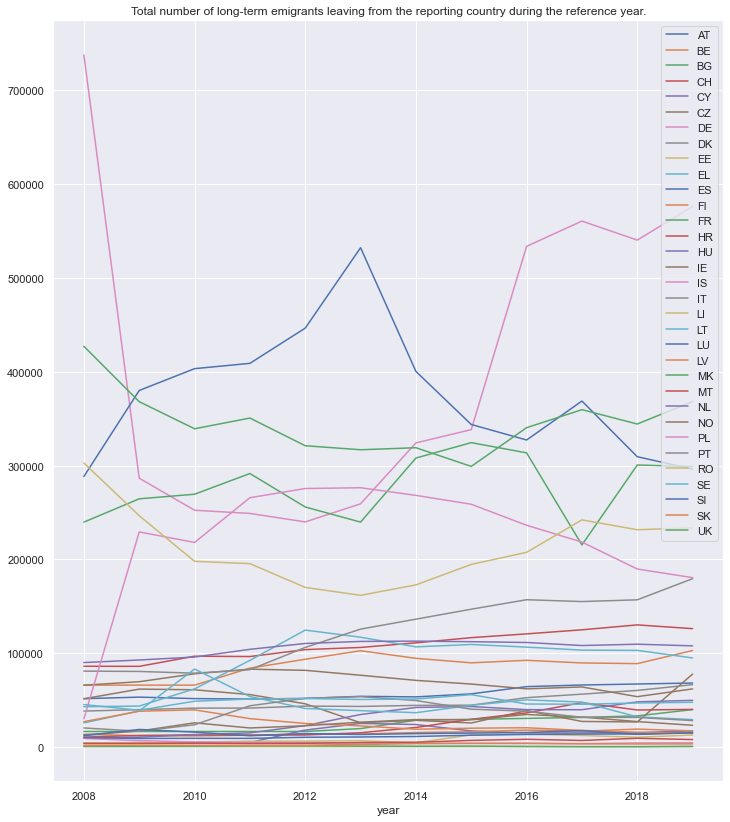

In [12]:
# -- plot timeseries ----
sns.set()
diagTitle = "Total number of long-term emigrants leaving from the reporting country during the reference year."
# 1 plot per country:
# _ = immigrationData.groupby('country').plot(figsize = [14,20]) 
# all countries in 1 plot:
_ = data.groupby('country')[VALUE_COLNAME].plot(figsize = [12,14], legend=True, title=diagTitle) 

In [13]:
# alternative: 1 col/country
#_= data.pivot(columns='country', values=VALUE_COLNAME).plot(figsize = [12,14], title=diagTitle)

In [14]:
if False:
    data.reset_index(inplace=True)
    data

In [15]:
# save processed data
data.to_csv(os.path.join(PATH_DATA, "population", "emigrants.csv"), index=True)